<a href="https://colab.research.google.com/github/kooose38/systematic-review-work-sigmate/blob/master/EDA_Aurgment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Systematic Review Work の EDA と Aurgments
目的: データの傾向の理解を図る。Positiveデータへの文章の水増しをする。  
環境: Python 3.7.11 google colab での実装


### load dataset 

In [1]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np 
import plotly.express as px 

In [2]:
df = pd.read_csv("train.csv", encoding="cp932")
df.sample(8)

,id,title,abstract,judgement
10631,10631,Lay perspectives on social distancing and othe...,BACKGROUND: COVID-19 caused by a new form of c...,0
23164,23164,Anomalously phosphorylated tau and Abeta fragm...,Alzheimer's disease (AD) is a neurodegenerativ...,0
8362,8362,Identification and comparative analysis of hum...,Short-chain fatty acids (SCFAs) butyrate prop...,0
19371,19371,Psychological distress among health care profe...,Objectives. - The present study aimed to asses...,0
2216,2216,Stroke Systems of Care During the COVID-19 Epi...,BACKGROUND: The novel coronavirus disease 2019...,0
16708,16708,PET and PET/CT studies of tumor tissue oxygena...,Hypoxia has been identified as a major adverse...,0
24542,24542,Delay discounting of compliance with containme...,Aim: Unprecedented community containment measu...,0
22769,22769,The virtual ward - the students' clinical educ...,"On March 17, 2020, the Swedish Government reco...",0


### EDA 

In [3]:
df.isnull().sum()

id              0
title           0
abstract     4390
judgement       0
dtype: int64

In [ ]:
labels = df["judgement"].value_counts()
fig = px.pie(values=labels.values, labels=labels.index, 
             title="Positive rate", names=labels.index)
fig.show()

ほとんどのデータがネガティブを占めている。

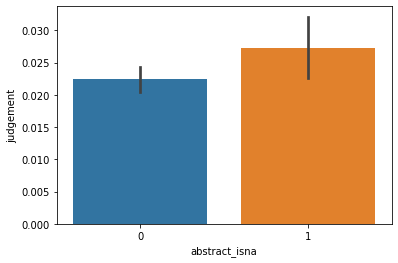

In [ ]:
df["abstract_isna"] = df.abstract.isnull().astype(int)
sns.barplot(data=df, x="abstract_isna", y="judgement")

本文がnanのものが若干だが、positiveになる。  
解釈: nanに正解ラベルが割合高く存在するのでタイトルを本文にする。nanは削れない。

In [7]:
except_word = [" ", " . ", "the", "a", "of", "and", "in", "to", "with", "for", "was", "were", 
               "is", "that", "this", "as", "we", "i", "I", "there", "they", "you", "", ".", "are", 
               "or", "at", "0", "these", "be", "on", "from", "alt", "has", "many", "ad"]

def get_vocab(df):
    vocab = {}
    for texts in df.abstract.to_list():
        if texts is np.nan: continue
        texts = texts.replace(".", " . ")
        texts = texts.lower()
        for text in texts.split(" "):
            text = text.strip()
            if text in except_word: continue
            if text not in vocab:
                vocab[text] = 1 
            else:
                vocab[text] += 1 
    return vocab 

from typing import Dict, List, Union 
def get_vocab_df(vocab: Dict[str, int], title: str):
    text = []
    cnt = []
    for k, v in vocab.items():
        text.append(k)
        cnt.append(v)
    cnt_vocab_df = pd.DataFrame({"word": text, "count": cnt}).sort_values("count", ascending=False)[:20]
    fig, ax = plt.subplots(figsize=(16, 6))
    sns.barplot(data=cnt_vocab_df, x="word", y="count", ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    plt.title(title)


all_vocab = get_vocab(df)
pos_vocab = get_vocab(df[df.judgement == 1])
neg_vocab = get_vocab(df[df.judgement == 0])

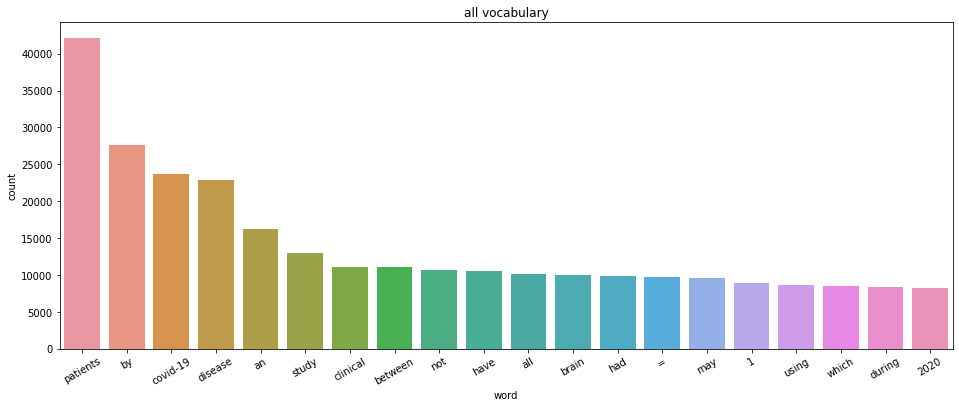

In [ ]:
get_vocab_df(all_vocab, "all vocabulary")

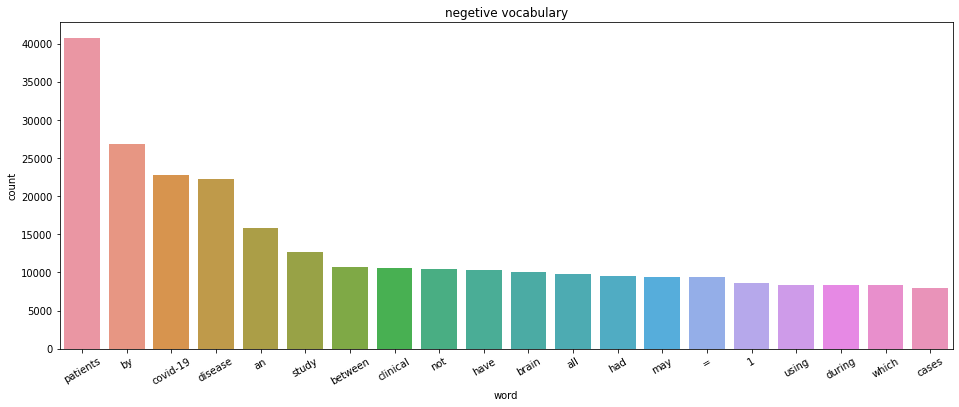

In [ ]:
get_vocab_df(neg_vocab, "negetive vocabulary")

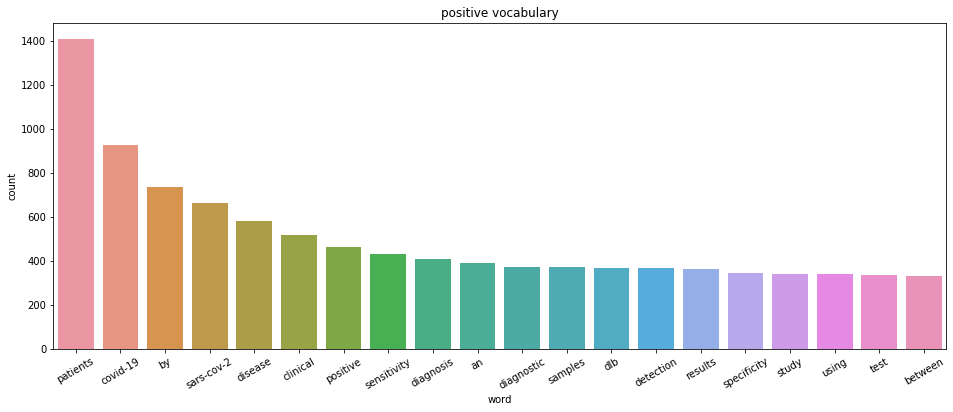

In [ ]:
get_vocab_df(pos_vocab, "positive vocabulary")

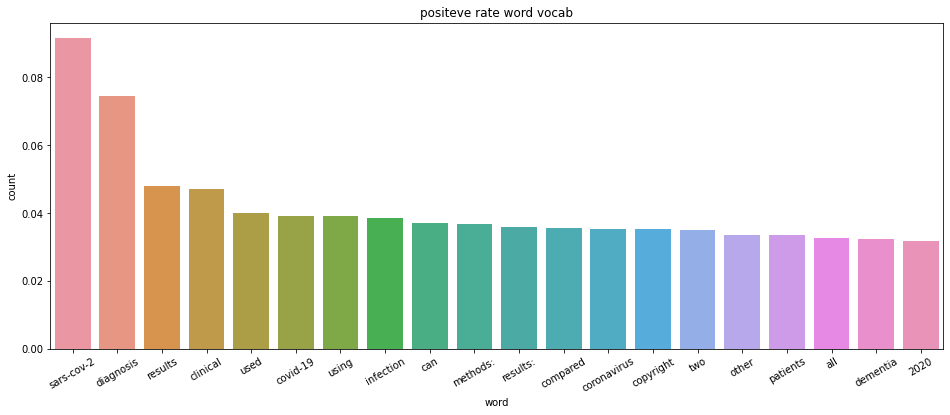

In [ ]:
same_word = {}
for all_w, all_len in all_vocab.items():
    if all_len <= 5000: continue
    for p_w, p_len in pos_vocab.items():
        if p_len <= 100: continue 
        if all_w == p_w:
            same_word[all_w] = p_len/all_len 
        
get_vocab_df(same_word, "positeve rate word vocab")

ポジティブ文章には**ウイルス**関係が多い印象

In [ ]:
len(df.title.value_counts().index) / df.shape[0] # titleに重複なし

1.0

最大のトークン数

In [10]:
max_len = 0 
for doc in df.abstract.to_list():
    if doc is np.nan: continue
    i = 0 
    for text in doc.strip().split(" "):
        i += 1 
    if max_len < i:
        max_len = i
print(f"max length in abstract vocab: {max_len}")

max length in abstract vocab: 1620


### Aurgements

In [14]:
!pip install -q gensim 

In [5]:
import  gensim.downloader as api 
pos = df[df.judgement == 1].abstract.to_list()
wv = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
import pickle 
with open("gensim-google.pkl", "wb") as f:
    pickle.dump(wv, f)

In [16]:
from typing import List 

dataset = []
for texts in pos:
    if texts is np.nan: continue
    texts = texts.replace(".", " . ")
    datas = []
    for text in texts.strip().split(" "):
        datas.append(text.strip())
    dataset.append(datas)

def random_text(doc: List[str]):
    for _ in doc:
        idx = np.random.randint(0, len(doc))
        word = doc[idx]
        if word in wv:
            return idx 
        else:
            return -1 


def do_augment(docs: List[List[str]], replace_rate=.2) -> List[List[str]]:
    augment = []
    for doc in docs:
        max_rate = int(len(doc)* replace_rate)

        doc_new = doc.copy()
        for _ in range(max_rate):
            idx = random_text(doc)
            if idx < 0:
                break 
            if doc_new[idx] in except_word: continue
            word = doc_new[idx]
            word_similar = wv.similar_by_word(word, topn=1)[0]
            doc_new[idx] = word_similar[0]
            # print(f"{word} -> {word_similar[0]} at {idx}")
        augment.append(doc_new)
    return augment 

def sentence_fn(augment: List[List[str]]) -> List[str]:
    sentence = []
    for doc in augment:
        sentence.append(" ".join(doc))
    return sentence


In [17]:
import time 
def create_argment(dataset: List[List[str]]) -> pd.DataFrame:
    start = time.time()
    aug1 = do_augment(dataset)
    set1 = sentence_fn(aug1)
    df_aug1 = pd.DataFrame({"abstract": set1, "judgement": 1, "abstract_isna": 0})
    end = time.time()
    print(f"duration time 1/3 {end-start}")
    aug2 = do_augment(aug1)
    set2 = sentence_fn(aug2)
    df_aug2 = pd.DataFrame({"abstract": set2, "judgement": 1, "abstract_isna": 0})
    end = time.time()
    print(f"duration time 2/3 {end-start}")
    # aug3 = do_augment(aug2)
    # set3 = sentence_fn(aug3)
    # df_aug3 = pd.DataFrame({"abstract": set3, "judgement": 1, "abstract_isna": 0})
    # end = time.time()
    # print(f"duration time 3/3 {end-start}"

    df_aug = pd.concat([df_aug1, df_aug2])
    return df_aug

In [18]:
df_aug = create_argment(dataset)

duration time 1/3 328.64500164985657
duration time 2/3 690.8989400863647


### preprocessing 

In [20]:
df["abstract"] = df.abstract.fillna(df.title)
df["abstract_isna"] =  df.abstract.isnull().astype(int)
df.drop(["title", "id"], axis=1, inplace=True)
df_ = pd.concat([df, df_aug])

import re 
def prep_text(text):
    p_text = []
    for t in text.strip().split(" "):
        t = re.sub(r" (.*?) ", "", t)
        t = re.sub(r"\u3000", "", t)
        t = t.lower()
        if t in except_word: continue
        if t == "":
            continue
        p_text.append(t)
    return " ".join(p_text)

df_["abstract"] = df_.abstract.apply(lambda x: prep_text(x))
df_ = df_.sample(frac=1)
df_.head()

,abstract,judgement,abstract_isna
5392,background: evaluate efficacy safety galantami...,0,0
23249,wuhan covid-19 intubation experience,0,0
24307,patients coronavirus disease 2019 (covid-19) h...,0,0
18734,protein aggregation underlies wide range human...,0,0
23579,objective: investigate application severity cl...,0,0


In [21]:
labels = df_["judgement"].value_counts()
fig = px.pie(values=labels.values, labels=labels.index, 
             title="Positive rate", names=labels.index)
fig.show()

### save 

In [22]:
df_.to_csv("train_prep.csv", index=False)